The purpose of this notebook is to check to make sure our data processing pipeline works.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# %qtconsole
# %pdb on
#%config InlineBackend.figure_format = 'retina'


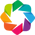

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import loren_frank_data_processing as lfdp
import spectral_connectivity
import ripple_detection
import replay_classification

import logging
logging.basicConfig(level=logging.INFO)

## Task Data

Make sure we can get information about the experimental setup

In [3]:
from src.parameters import ANIMALS

epoch_info = lfdp.make_epochs_dataframe(ANIMALS)
epoch_info

environment   type  exposure
animal day epoch                                    
JZ1    1   1                  sleep  sleep       NaN
           2                 wtrack    run       1.0
           3                  sleep  sleep       NaN
           4                 wtrack    run       2.0
           5                  sleep  sleep       NaN
           6              openfield    run       1.0
           7                  sleep  sleep       NaN
           8              openfield    run       2.0
           9                  sleep  sleep       NaN
       2   1                  sleep  sleep       NaN
           2                 wtrack    run       3.0
           3                  sleep  sleep       NaN
           4                 wtrack    run       4.0
           5                  sleep  sleep       NaN
           6              openfield    run       3.0
           7                  sleep  sleep       NaN
           8              openfield    run       4.0
           9                  sleep  sleep       NaN
       3   1                  sleep  sleep       NaN
           2                 wtrack    run       5.0
           3                  sleep  sleep       NaN
           4                 wtrack    run       6.0
           5                  sleep  sleep       NaN
           6              openfield    run       5.0
           7                  sleep  sleep       NaN
           8              openfield    run       6.0
           9                  sleep  sleep       NaN
       4   1                  sleep  sleep       NaN
           2                 wtrack    run       7.0
           3                  sleep  sleep       NaN
...                             ...    ...       ...
       11  7                  sleep  sleep       NaN
           8              openfield    run      22.0
           9                  sleep  sleep       NaN
       12  1                  sleep  sleep       NaN
           2      sixarmtrack_right    run       5.0
           3                  sleep  sleep       NaN
           4      sixarmtrack_right    run       6.0
           5                  sleep  sleep       NaN
           6              openfield    run      23.0
           7                  sleep  sleep       NaN
           8              openfield    run      24.0
           9                  sleep  sleep       NaN
       13  1                  sleep  sleep       NaN
           2      sixarmtrack_right    run       7.0
           3                  sleep  sleep       NaN
           4      sixarmtrack_right    run       8.0
           5                  sleep  sleep       NaN
           6              openfield    run      25.0
           7                  sleep  sleep       NaN
           8              openfield    run      26.0
           9                  sleep  sleep       NaN
       14  1                  sleep  sleep       NaN
           2      sixarmtrack_right    run       9.0
           3                  sleep  sleep       NaN
           4      sixarmtrack_right    run      10.0
           5                  sleep  sleep       NaN
           6              openfield    run      27.0
           7                  sleep  sleep       NaN
           8              openfield    run      28.0
           9                  sleep  sleep       NaN

[126 rows x 3 columns]

In [4]:
epoch_key = ('JZ1', 1, 2)

## Position Data
Make sure we can get the 2D and linear position

In [5]:
position_info = lfdp.get_interpolated_position_dataframe(
    epoch_key, ANIMALS, max_distance_from_well=5)
position_info.head()

labeled_segments from_well to_well task is_correct  \
time                                                                  
00:28:00.085200               1.0       NaN     NaN  NaN        NaN   
00:28:00.085867               1.0       NaN     NaN  NaN        NaN   
00:28:00.086533               1.0       NaN     NaN  NaN        NaN   
00:28:00.087200               1.0       NaN     NaN  NaN        NaN   
00:28:00.087867               1.0       NaN     NaN  NaN        NaN   

                 x_position  y_position  head_direction     speed  \
time                                                                
00:28:00.085200   47.222953    51.47623       -3.077724  5.142901   
00:28:00.085867   47.222953    51.47623       -3.077724  5.142901   
00:28:00.086533   47.222953    51.47623       -3.077724  5.142901   
00:28:00.087200   47.222953    51.47623       -3.077724  5.142901   
00:28:00.087867   47.222953    51.47623       -3.077724  5.142901   

                 linear_distance  
time                              
00:28:00.085200        42.241868  
00:28:00.085867        42.241868  
00:28:00.086533        42.241868  
00:28:00.087200        42.241868  
00:28:00.087867        42.241868

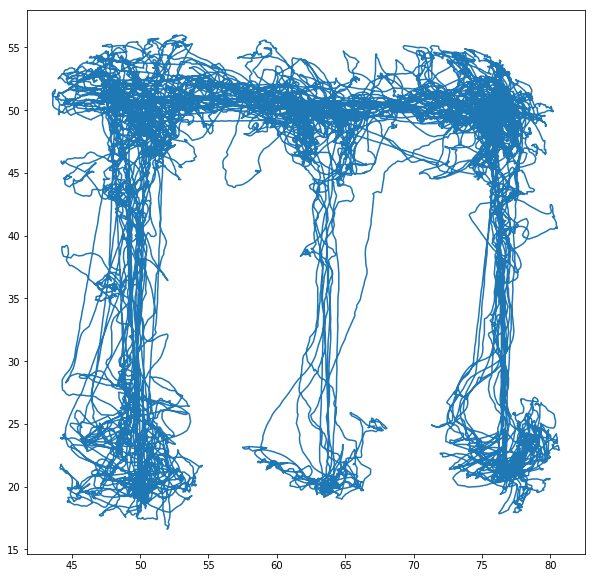

In [6]:
plt.figure(figsize=(10, 10))
plt.plot(position_info.x_position.values, position_info.y_position.values);

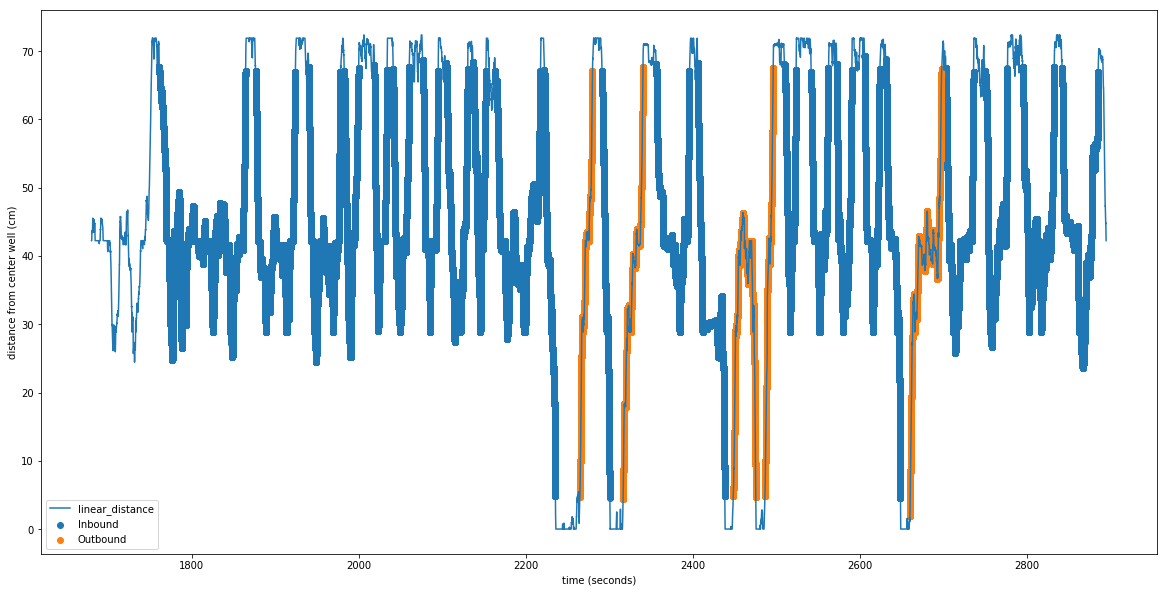

In [11]:
plt.figure(figsize=(20, 10))

plt.plot(position_info.index.total_seconds(), position_info.linear_distance)

for label, df in position_info.groupby('task'):
    plt.scatter(df.index.total_seconds(), df.linear_distance, label=label)

plt.xlabel('time (seconds)')
plt.ylabel('distance from center well (cm)')
plt.legend();

3


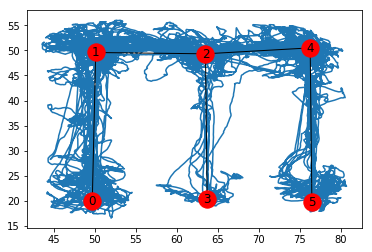

In [12]:
track_graph, center_well_id = lfdp.position.make_track_graph(epoch_key, ANIMALS)
plt.plot(position_info.x_position.values, position_info.y_position.values, zorder=-1);
lfdp.track_segment_classification.plot_track(track_graph, ax=None)

print(center_well_id)

In [13]:
lfdp.__file__

'/home/droumis/anaconda3/envs/Roumis_2018/lib/python3.6/site-packages/loren_frank_data_processing/__init__.py'

In [14]:
position_df = lfdp.position.get_position_dataframe(epoch_key, ANIMALS)
position = position_df.loc[:, ['x_position', 'y_position']].values
track_segment_id = lfdp.track_segment_classification.classify_track_segments(
    track_graph, position,
    route_euclidean_distance_scaling=1E-1)


In [15]:
linear_distance = lfdp.track_segment_classification.calculate_linear_distance(
    track_graph, track_segment_id, center_well_id, position)

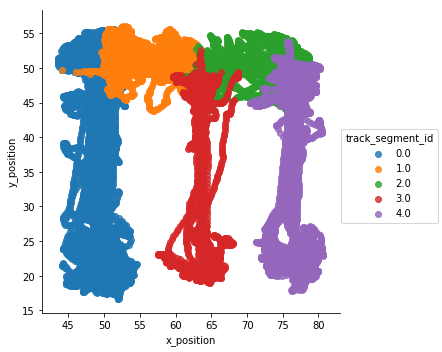

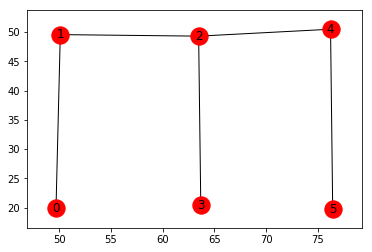

In [16]:
position_df['track_segment_id'] = track_segment_id
sns.lmplot('x_position', 'y_position', data=position_df , hue='track_segment_id', fit_reg=False)

plt.figure()
lfdp.track_segment_classification.plot_track(track_graph, ax=None)

In [17]:
def plot_linear_distance(linear_distance, position, indices):
    time_ind = slice(*indices)
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    axes[0].plot(linear_distance[time_ind], linewidth=2, label='HMM')
    axes[0].set_xlabel('time')
    axes[0].set_ylabel('distance (cm)')
    axes[0].legend();
    
    axes[1].plot(position[:, 0], position[:, 1])
    axes[1].plot(position[time_ind][:, 0], position[time_ind][:, 1],
                 linewidth=3)
    start_stop = position[time_ind][[0, -1], :]
    axes[1].scatter(start_stop[0, 0], start_stop[0, 1],
                    label='start', color='lightgreen', s=100, zorder=1000)
    axes[1].scatter(start_stop[1, 0], start_stop[1, 1],
                    label='stop', color='red', s=100, zorder=1000)
    axes[1].legend()
    

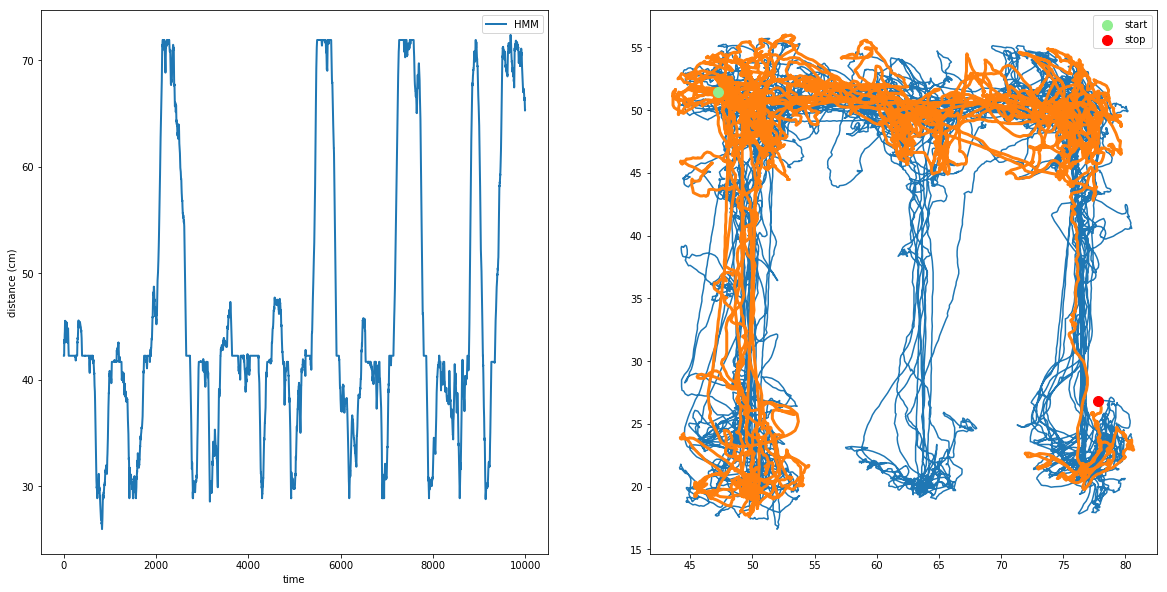

In [18]:
plot_linear_distance(linear_distance, position, (0, 10000))

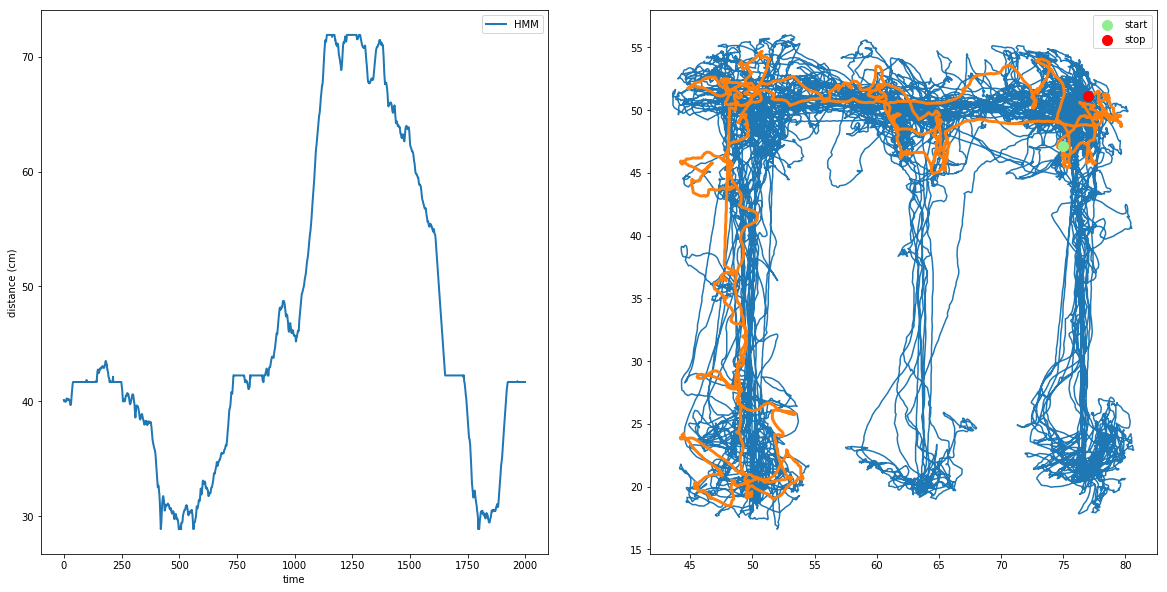

In [19]:
plot_linear_distance(linear_distance, position, (1000, 3000))

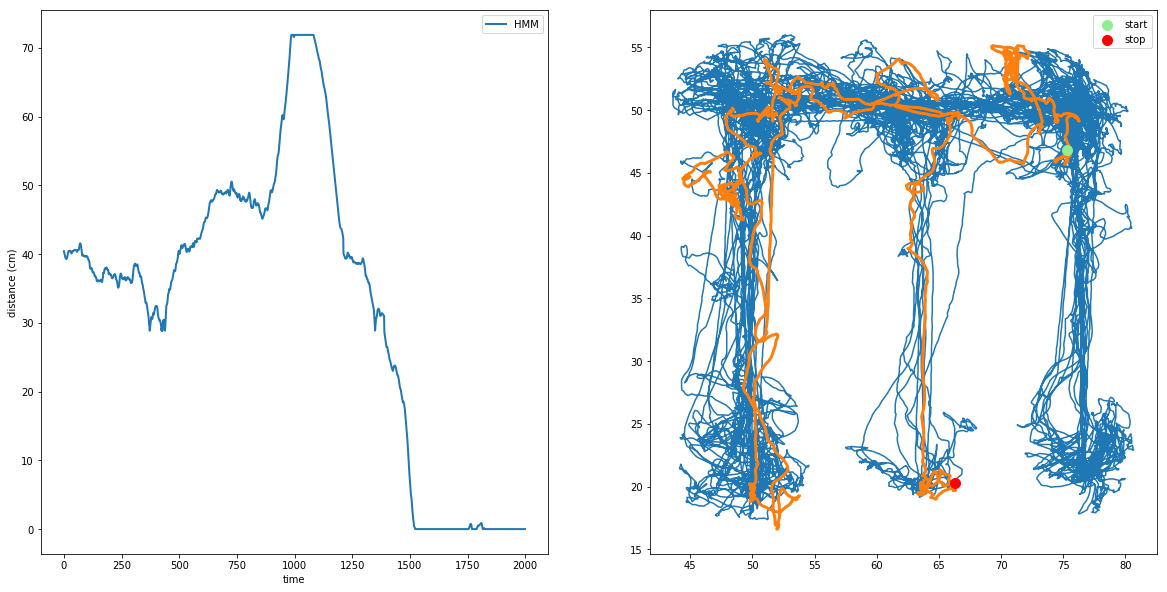

In [20]:
plot_linear_distance(linear_distance, position, (15000, 17000))

## Tetrode Data

Make sure we can get information about the tetrode locations

In [7]:
tetrode_info = lfdp.make_tetrode_dataframe(ANIMALS).xs(epoch_key, drop_level=False)

In [8]:
tetrode_info

area  depth  nchans  numcells   ref subarea  \
animal day epoch tetrode_number                                               
JZ1    1   2     1               mec      0       4         0  11.0       2   
                 2               mec      0       4         0  11.0       5   
                 3               mec      0       8         0  11.0       5   
                 4               mec      0       4         0  11.0       6   
                 5               sub      0       4         0  11.0       d   
                 6               mec      0       4         0  11.0       6   
                 7               mec      0       4         0  11.0       5   
                 8               mec      0       4         0  11.0       2   
                 9               mec      0       4         0  11.0       2   
                 10              mec      0       8         0  11.0       3   
                 11              ref      0       4         0   NaN           
                 12              v2l      0       4         0  11.0       6   
                 13              por      0       4         0  11.0       6   
                 14              mec      0       4         0  11.0       6   
                 15              por      0       4         0  11.0       6   
                 16              ca1      0       4         0  11.0       d   
                 17              ca1      0       4         0  11.0       d   
                 18              ca1      0       4         0  11.0       d   
                 19              ca1      0       4         0  11.0       d   
                 20              ca1      0       4         0  11.0       d   
                 21              ca1      0       4         0  11.0       d   
                 22              ca1      0       4         0  11.0       d   
                 23              ca1      0       4         0  11.0       d   
                 24              ca1      0       4         0  11.0       d   
                 25              ca1      0       4         0  11.0       d   
                 26              ca1      0       4         0  11.0       d   
                 27              ca1      0       4         0  11.0       d   
                 28              ca1      0       4         0  11.0       d   
                 29              ca1      0       4         0  11.0       d   
                 30              ca1      0       4         0  11.0       d   

                                suparea     tetrode_id  
animal day epoch tetrode_number                         
JZ1    1   2     1                  ctx  JZ1_01_02_001  
                 2                  ctx  JZ1_01_02_002  
                 3                  ctx  JZ1_01_02_003  
                 4                  ctx  JZ1_01_02_004  
                 5                  hpc  JZ1_01_02_005  
                 6                  ctx  JZ1_01_02_006  
                 7                  ctx  JZ1_01_02_007  
                 8                  ctx  JZ1_01_02_008  
                 9                  ctx  JZ1_01_02_009  
                 10                 ctx  JZ1_01_02_010  
                 11                      JZ1_01_02_011  
                 12                 ctx  JZ1_01_02_012  
                 13                 ctx  JZ1_01_02_013  
                 14                 ctx  JZ1_01_02_014  
                 15                 ctx  JZ1_01_02_015  
                 16                 hpc  JZ1_01_02_016  
                 17                 hpc  JZ1_01_02_017  
                 18                 hpc  JZ1_01_02_018  
                 19                 hpc  JZ1_01_02_019  
                 20                 hpc  JZ1_01_02_020  
                 21                 hpc  JZ1_01_02_021  
                 22                 hpc  JZ1_01_02_022  
                 23                 hpc  JZ1_01_02_023  
                 24                 hpc  JZ1_01_02_024  
                 25  

## Detect Ripples

Make sure we can detect ripples

In [9]:
is_brain_areas = tetrode_info.area.isin(['ca1'])
tetrode_keys = tetrode_info[is_brain_areas].index.tolist()
tetrode_info[is_brain_areas].loc[:, ['area']]

area
animal day epoch tetrode_number     
JZ1    1   2     16              ca1
                 17              ca1
                 18              ca1
                 19              ca1
                 20              ca1
                 21              ca1
                 22              ca1
                 23              ca1
                 24              ca1
                 25              ca1
                 26              ca1
                 27              ca1
                 28              ca1
                 29              ca1
                 30              ca1

In [10]:
position_info.head()

labeled_segments from_well to_well task is_correct  \
time                                                                  
00:28:00.085200               1.0       NaN     NaN  NaN        NaN   
00:28:00.085867               1.0       NaN     NaN  NaN        NaN   
00:28:00.086533               1.0       NaN     NaN  NaN        NaN   
00:28:00.087200               1.0       NaN     NaN  NaN        NaN   
00:28:00.087867               1.0       NaN     NaN  NaN        NaN   

                 x_position  y_position  head_direction     speed  \
time                                                                
00:28:00.085200   47.222953    51.47623       -3.077724  5.142901   
00:28:00.085867   47.222953    51.47623       -3.077724  5.142901   
00:28:00.086533   47.222953    51.47623       -3.077724  5.142901   
00:28:00.087200   47.222953    51.47623       -3.077724  5.142901   
00:28:00.087867   47.222953    51.47623       -3.077724  5.142901   

                 linear_distance  
time                              
00:28:00.085200        42.241868  
00:28:00.085867        42.241868  
00:28:00.086533        42.241868  
00:28:00.087200        42.241868  
00:28:00.087867        42.241868

In [42]:
# speed = position_info.speed
# speed = lfdp.get_interpolated_position_dataframe(
#     epoch_key, ANIMALS).speed


In [11]:
tetrode_keys

[('JZ1', 1, 2, 16),
 ('JZ1', 1, 2, 17),
 ('JZ1', 1, 2, 18),
 ('JZ1', 1, 2, 19),
 ('JZ1', 1, 2, 20),
 ('JZ1', 1, 2, 21),
 ('JZ1', 1, 2, 22),
 ('JZ1', 1, 2, 23),
 ('JZ1', 1, 2, 24),
 ('JZ1', 1, 2, 25),
 ('JZ1', 1, 2, 26),
 ('JZ1', 1, 2, 27),
 ('JZ1', 1, 2, 28),
 ('JZ1', 1, 2, 29),
 ('JZ1', 1, 2, 30)]

In [12]:
hippocampus_lfps = lfdp.get_LFPs(tetrode_keys, ANIMALS)
time = hippocampus_lfps.index

speed = lfdp.get_interpolated_position_dataframe(
    epoch_key, ANIMALS).speed

sampling_frequency = 1500

ripple_times = ripple_detection.Kay_ripple_detector(
        time, hippocampus_lfps.values, speed.values, sampling_frequency,
        minimum_duration=pd.Timedelta(milliseconds=15), zscore_threshold=3)

In [13]:
ripple_times

start_time        end_time
ripple_number                                
1             00:28:03.733867 00:28:03.821867
2             00:28:04.379200 00:28:04.437867
3             00:28:07.081867 00:28:07.135200
4             00:28:08.576533 00:28:08.680533
5             00:28:09.424533 00:28:09.501200
6             00:28:13.159200 00:28:13.207200
7             00:28:13.710533 00:28:13.776533
8             00:28:14.932533 00:28:15.001200
9             00:28:16.880533 00:28:16.961867
10            00:28:19.627867 00:28:19.706533
11            00:28:34.423200 00:28:34.734533
12            00:28:35.351200 00:28:35.719200
13            00:28:39.040533 00:28:39.099867
14            00:28:39.481200 00:28:39.554533
15            00:28:40.797200 00:28:40.913200
16            00:28:41.599200 00:28:41.693200
17            00:28:41.745200 00:28:41.881200
18            00:28:41.889200 00:28:41.941867
19            00:28:42.887867 00:28:43.182533
20            00:28:46.689867 00:28:46.747200
21            00:28:46.907867 00:28:46.964533
22            00:28:47.111867 00:28:47.191867
23            00:28:47.287867 00:28:47.331867
24            00:28:48.939200 00:28:48.997867
25            00:28:49.837200 00:28:49.895867
26            00:28:51.035867 00:28:51.097867
27            00:28:52.433200 00:28:52.499200
28            00:28:53.037200 00:28:53.093867
29            00:28:54.118533 00:28:54.175867
30            00:28:57.065866 00:28:57.110533
...                       ...             ...
355           00:46:47.846533 00:46:48.002533
356           00:46:52.401200 00:46:52.519200
357           00:46:54.272533 00:46:54.391867
358           00:46:55.495200 00:46:55.540533
359           00:47:00.201200 00:47:00.272533
360           00:47:00.670533 00:47:00.720533
361           00:47:01.207200 00:47:01.247867
362           00:47:03.746533 00:47:03.834533
363           00:47:06.873200 00:47:06.920533
364           00:47:10.161200 00:47:10.259200
365           00:47:20.131867 00:47:20.201200
366           00:47:21.204533 00:47:21.275200
367           00:47:26.610533 00:47:26.661200
368           00:47:27.337867 00:47:27.445200
369           00:47:27.779867 00:47:27.872533
370           00:47:32.038533 00:47:32.137867
371           00:47:32.321867 00:47:32.401867
372           00:47:34.004533 00:47:34.095200
373           00:47:34.160533 00:47:34.266533
374           00:47:34.854533 00:47:34.911200
375           00:47:35.237200 00:47:35.306533
376           00:47:38.977867 00:47:39.070533
377           00:47:39.923200 00:47:39.998533
378           00:47:40.114533 00:47:40.220533
379           00:47:44.371867 00:47:44.476533
380           00:47:46.019867 00:47:46.074533
381           00:47:47.877200 00:47:47.968533
382           00:47:49.119200 00:47:49.192533
383           00:47:49.429200 00:47:49.509866
384           00:48:02.653200 00:48:02.783867

[384 rows x 2 columns]

##  Ripple Power

Make sure we get ripple band power for detected ripples.

In [14]:
window_offset = (-0.5, 0.5)

ripple_locked_LFPs = lfdp.reshape_to_segments(
    hippocampus_lfps, ripple_times,
    window_offset=window_offset, sampling_frequency=sampling_frequency)
ripple_locked_LFPs.columns = tetrode_info[is_brain_areas].tetrode_id

In [15]:
ripple_locked_LFPs = (ripple_locked_LFPs.to_xarray()
                      .to_array(dim='signals').transpose('time', 'ripple_number', 'signals'))

In [ ]:
m = spectral_connectivity.Multitaper(
    ripple_locked_LFPs.values, sampling_frequency, time_window_duration=0.100,
    time_halfbandwidth_product=3, start_time=window_offset[0])

In [ ]:
c = spectral_connectivity.Connectivity.from_multitaper(m)

In [ ]:
ripple_locked_power = xr.DataArray(
    c.power(), dims=('time', 'frequency', 'signals'),
    coords=dict(time=c.time + 0.050, frequency=c.frequencies), name='power')

In [ ]:
m = spectral_connectivity.Multitaper(
    hippocampus_lfps.values, sampling_frequency, time_window_duration=0.100,
    time_halfbandwidth_product=3, start_time=hippocampus_lfps.index.total_seconds()[0])
c = spectral_connectivity.Connectivity.from_multitaper(m)
power = xr.DataArray(
    c.power(), dims=('time', 'frequency', 'signals'),
    coords=dict(time=c.time + 0.050, frequency=c.frequencies), name='power')


In [ ]:
from matplotlib.colors import LogNorm

vmin, vmax = 0.5, 5

(ripple_locked_power / power.mean('time')).sel(frequency=slice(0, 500)).plot(
    x='time', y='frequency', col='signals', col_wrap=5, center=0,
    norm=LogNorm(vmin=vmin, vmax=vmax), vmin=vmin, vmax=vmax,
    cmap='RdBu_r');

In [16]:
ripple_duration = ripple_times.end_time.dt.total_seconds() - ripple_times.start_time.dt.total_seconds()

In [17]:
ripple_filtered_LFPs = pd.DataFrame(
    np.stack([ripple_detection.filter_ripple_band(lfp, sampling_frequency)
              for lfp in hippocampus_lfps.values.T], axis=1),
    index=time, columns=tetrode_keys)

In [18]:
ripple_locked_filtered_LFPs = lfdp.reshape_to_segments(
    ripple_filtered_LFPs, ripple_times, window_offset=window_offset,
    sampling_frequency=sampling_frequency)

In [19]:
m = spectral_connectivity.Multitaper(hippocampus_lfps.values, sampling_frequency, time_window_duration=0.020,
                                     time_window_step=0.004,
               time_halfbandwidth_product=1, start_time=time.total_seconds()[0])
c = spectral_connectivity.Connectivity.from_multitaper(m)
ripple_power = xr.DataArray(c.power(), dims=('time', 'frequency', 'signals'),
                            coords=dict(time=pd.TimedeltaIndex(c.time, unit='s'), frequency=c.frequencies), name='power')
ripple_power = ripple_power.sel(frequency=200).reindex(time)
ripple_power /= ripple_power.mean('time')
ripple_locked_power = lfdp.reshape_to_segments(
    ripple_power.drop('frequency').to_dataframe().unstack(), ripple_times, window_offset,
    sampling_frequency=sampling_frequency)

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1,
           time_window_duration=0.02, time_window_step=0.004,
           detrend_type='constant', start_time=1680.0852000000002, n_tapers=1)


In [19]:
n_ripples

NameError: name 'n_ripples' is not defined

In [ ]:
from ipywidgets import interact

ripple_time = ripple_locked_LFPs.get_index('time').total_seconds().values

def plot_lfp(ripple_number=1):
    n_LFPs = hippocampus_lfps.shape[1]
    fig, axes = plt.subplots(n_LFPs, 3, figsize=(20, 10), sharex=True)
    for ax, lfp in zip(
            axes[:, 0], ripple_locked_LFPs.loc[ripple_number].values.T):
        ax.plot(ripple_time, lfp)
        ax.axvspan(0, ripple_duration.loc[ripple_number], alpha=0.2)
        ax.axhline(0, color='black', linestyle='--')

    for ax, lfp in zip(
            axes[:, 1], ripple_locked_filtered_LFPs.loc[ripple_number].values.T):
        ax.plot(ripple_time, lfp, color='orange')
        ax.axvspan(0, ripple_duration.loc[ripple_number], alpha=0.2)
        ax.axhline(0, color='black', linestyle='--')

    power_time = ripple_locked_power.loc[ripple_number].index.total_seconds().values
    for ax, p in zip(axes[:, 2], ripple_locked_power.loc[ripple_number].values.T):
        ax.plot(power_time, p, color='purple')
        ax.axvspan(0, ripple_duration.loc[ripple_number], alpha=0.2)
        ax.axhline(1, color='black', linestyle='--')

    axes[0, 0].set_title('LFP')
    axes[0, 1].set_title('Bandpass Filtered LFP (150 - 250 Hz)')
    axes[0, 2].set_title('Ripple Power Change');

n_ripples = len(ripple_times)
interact(plot_lfp, ripple_number=(1, n_ripples), continuous_update=True);

## Theta Power

Make sure there is hippocampal theta present

In [43]:
ca1_keys = tetrode_info.query('area == "ca1"').index
ca1_lfps = lfdp.get_LFPs(ca1_keys, ANIMALS)
m = spectral_connectivity.Multitaper(
    ca1_lfps.values, sampling_frequency, time_window_duration=3.000,
    time_halfbandwidth_product=3, start_time=ca1_lfps.index.total_seconds()[0])
c = spectral_connectivity.Connectivity.from_multitaper(m)
theta_power = xr.DataArray(
    c.power(), dims=('time', 'frequency', 'signals'),
    coords=dict(time=c.time + 0.500, frequency=c.frequencies, signals=ca1_keys), name='power')
m.frequency_resolution

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=3,
           time_window_duration=3.0, time_window_step=3.0,
           detrend_type='constant', start_time=1680.0852000000002, n_tapers=5)


1.0

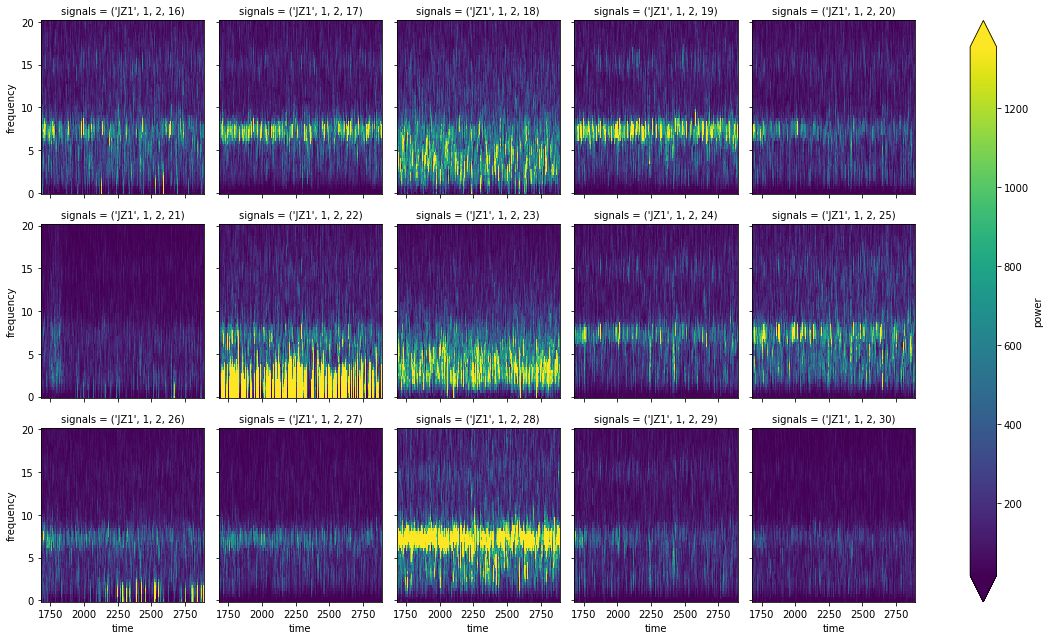

In [44]:
theta_power.sel(frequency=slice(0, 20)).plot(x='time', y='frequency', col='signals', col_wrap=5, robust=True);

Make sure MEC theta exists

In [47]:
mec_keys = tetrode_info.query('area == "mec"').index
mec_lfps = lfdp.get_LFPs(mec_keys, ANIMALS)
m = spectral_connectivity.Multitaper(
    mec_lfps.values, sampling_frequency, time_window_duration=3.000,
    time_halfbandwidth_product=3, start_time=mec_lfps.index.total_seconds()[0])
c = spectral_connectivity.Connectivity.from_multitaper(m)
theta_power = xr.DataArray(
    c.power(), dims=('time', 'frequency', 'signals'),
    coords=dict(time=c.time + 0.500, frequency=c.frequencies, signals=mec_keys), name='power')
m.frequency_resolution

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=3,
           time_window_duration=3.0, time_window_step=3.0,
           detrend_type='constant', start_time=1680.0852000000002, n_tapers=5)


1.0

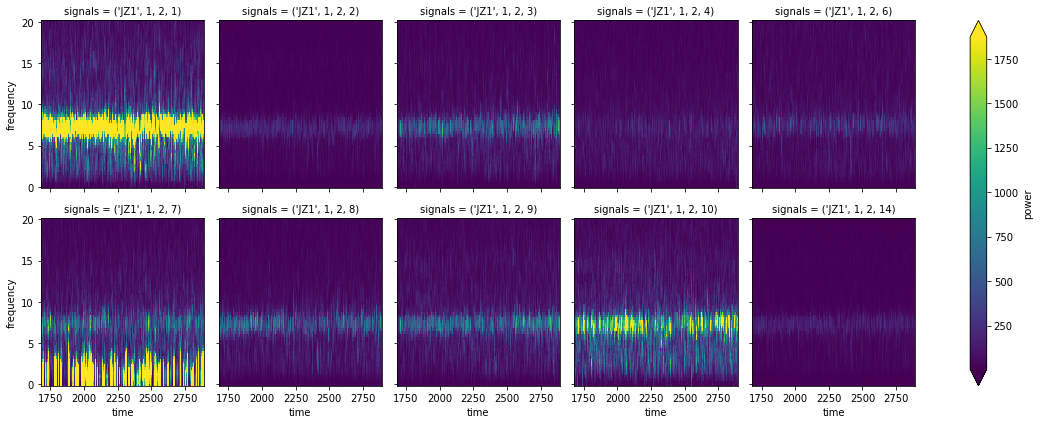

In [48]:
theta_power.sel(frequency=slice(0, 20)).plot(x='time', y='frequency', col='signals', col_wrap=5, robust=True);

## Gamma Power

In [56]:
ca1_keys = tetrode_info.query('area == "ca1"').index
ca1_lfps = lfdp.get_LFPs(ca1_keys, ANIMALS)
m = spectral_connectivity.Multitaper(
    ca1_lfps.values[speed > 4], sampling_frequency, time_window_duration=0.200,
    time_halfbandwidth_product=3, start_time=ca1_lfps.index.total_seconds()[0])
c = spectral_connectivity.Connectivity.from_multitaper(m)
gamma_power = xr.DataArray(
    c.power(), dims=('time', 'frequency', 'signals'),
    coords=dict(time=c.time + m.time_window_duration / 2, frequency=c.frequencies,
                signals=tetrode_info.query('area == "ca1"').tetrode_id), name='power')
m.frequency_resolution

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=3,
           time_window_duration=0.2, time_window_step=0.2,
           detrend_type='constant', start_time=1680.0852000000002, n_tapers=5)


15.0

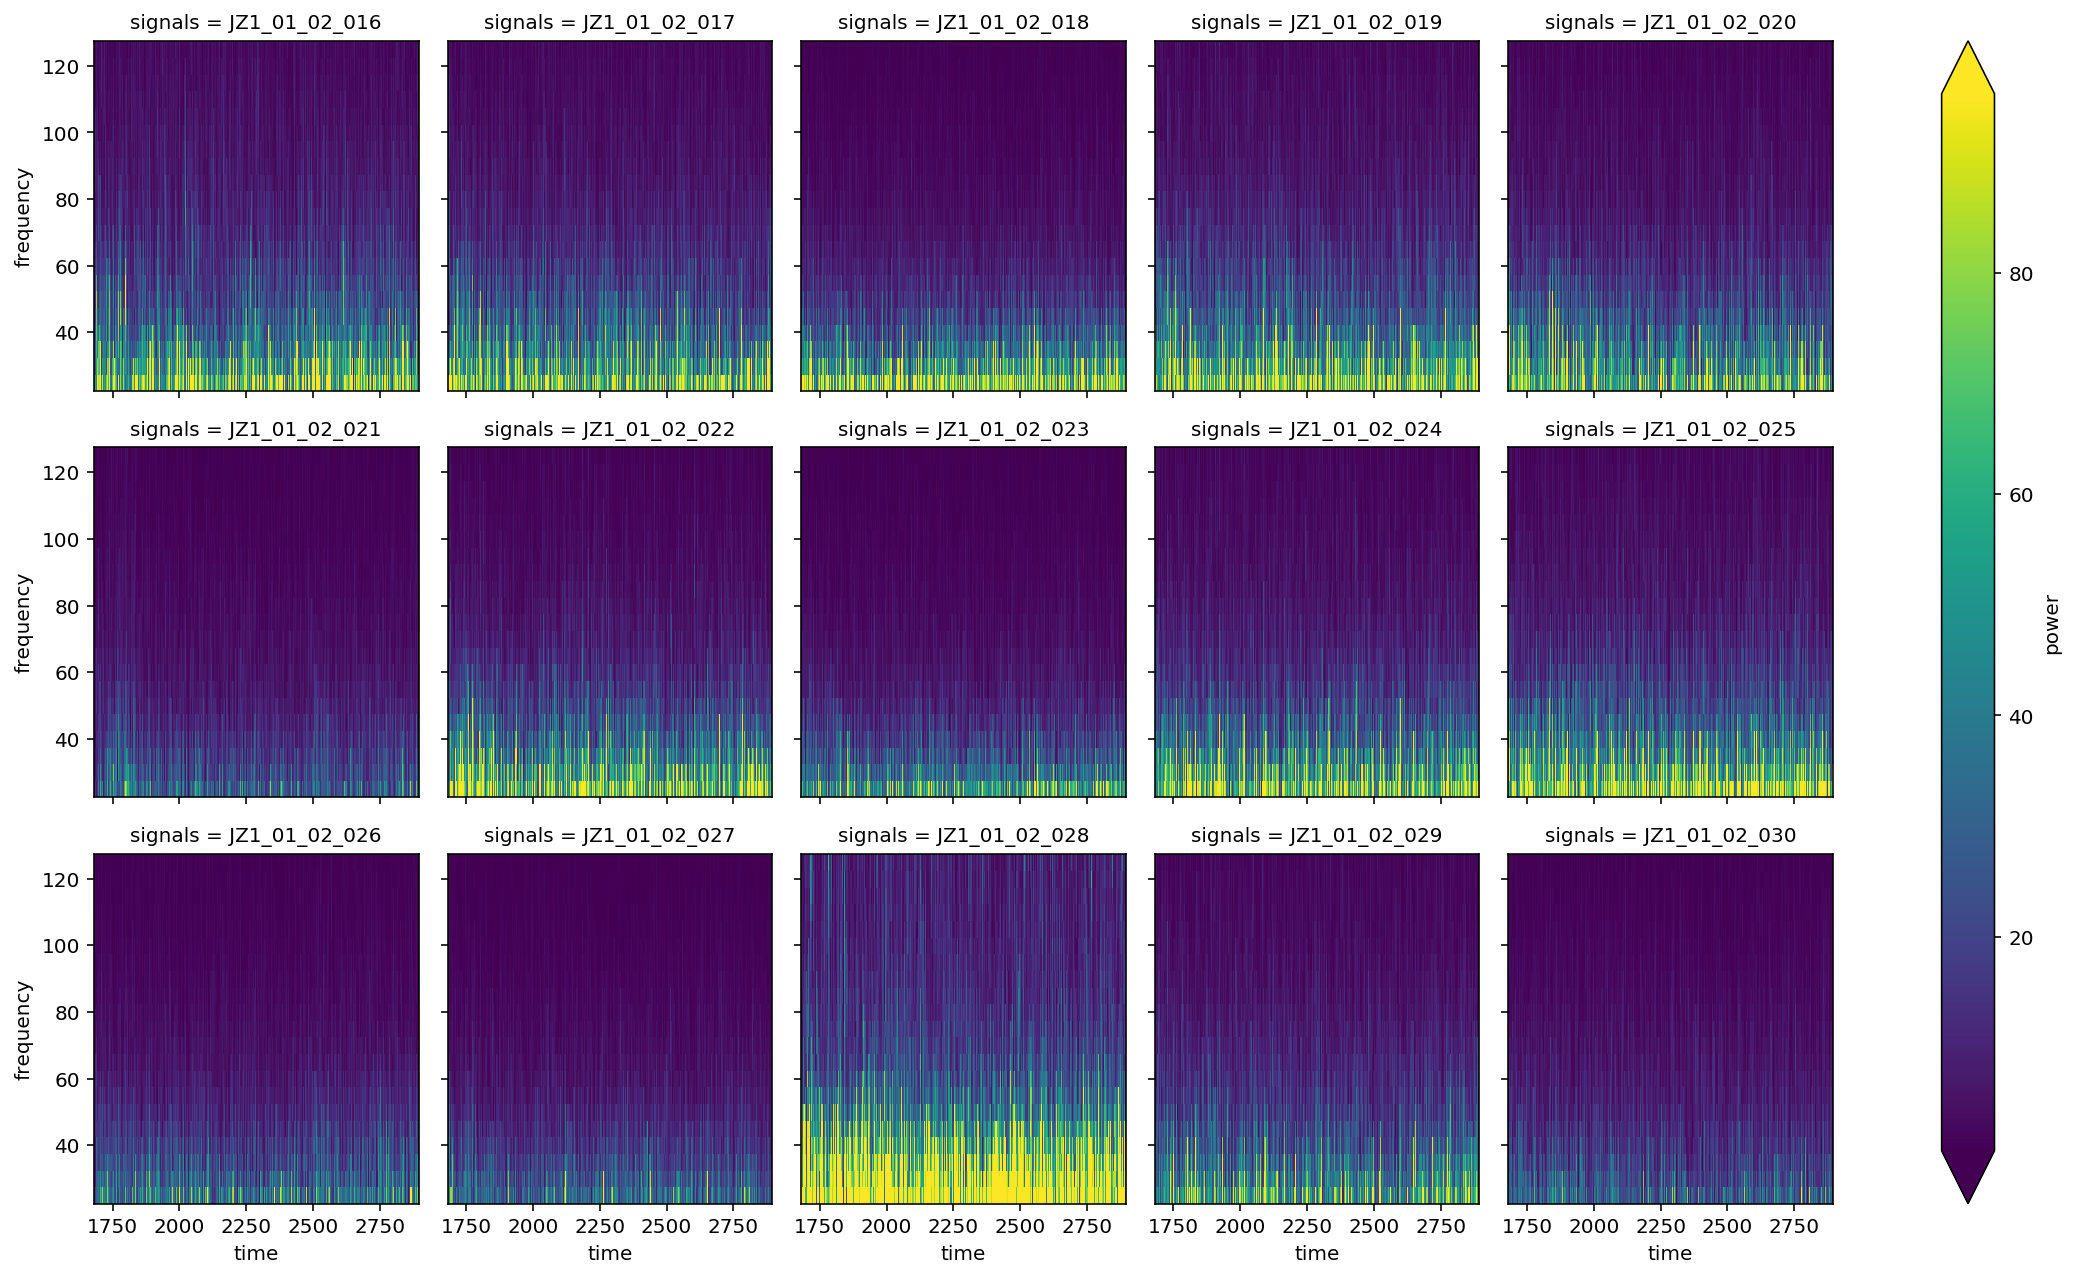

In [57]:
gamma_power.sel(frequency=slice(25, 125)).plot(x='time', y='frequency', col='signals', col_wrap=5, robust=True);

In [59]:
m = spectral_connectivity.Multitaper(
    ca1_lfps[speed > 4].values, sampling_frequency,
    time_halfbandwidth_product=9, start_time=ca1_lfps.index.total_seconds()[0])
c = spectral_connectivity.Connectivity.from_multitaper(m)
gamma_power = xr.DataArray(
    c.power(), dims=('time', 'frequency', 'signals'),
    coords=dict(time=c.time + m.time_window_duration / 2, frequency=c.frequencies,
                signals=tetrode_info.query('area == "ca1"').tetrode_id), name='power')


INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=9,
           time_window_duration=292.24, time_window_step=292.24,
           detrend_type='constant', start_time=1680.0852000000002, n_tapers=17)


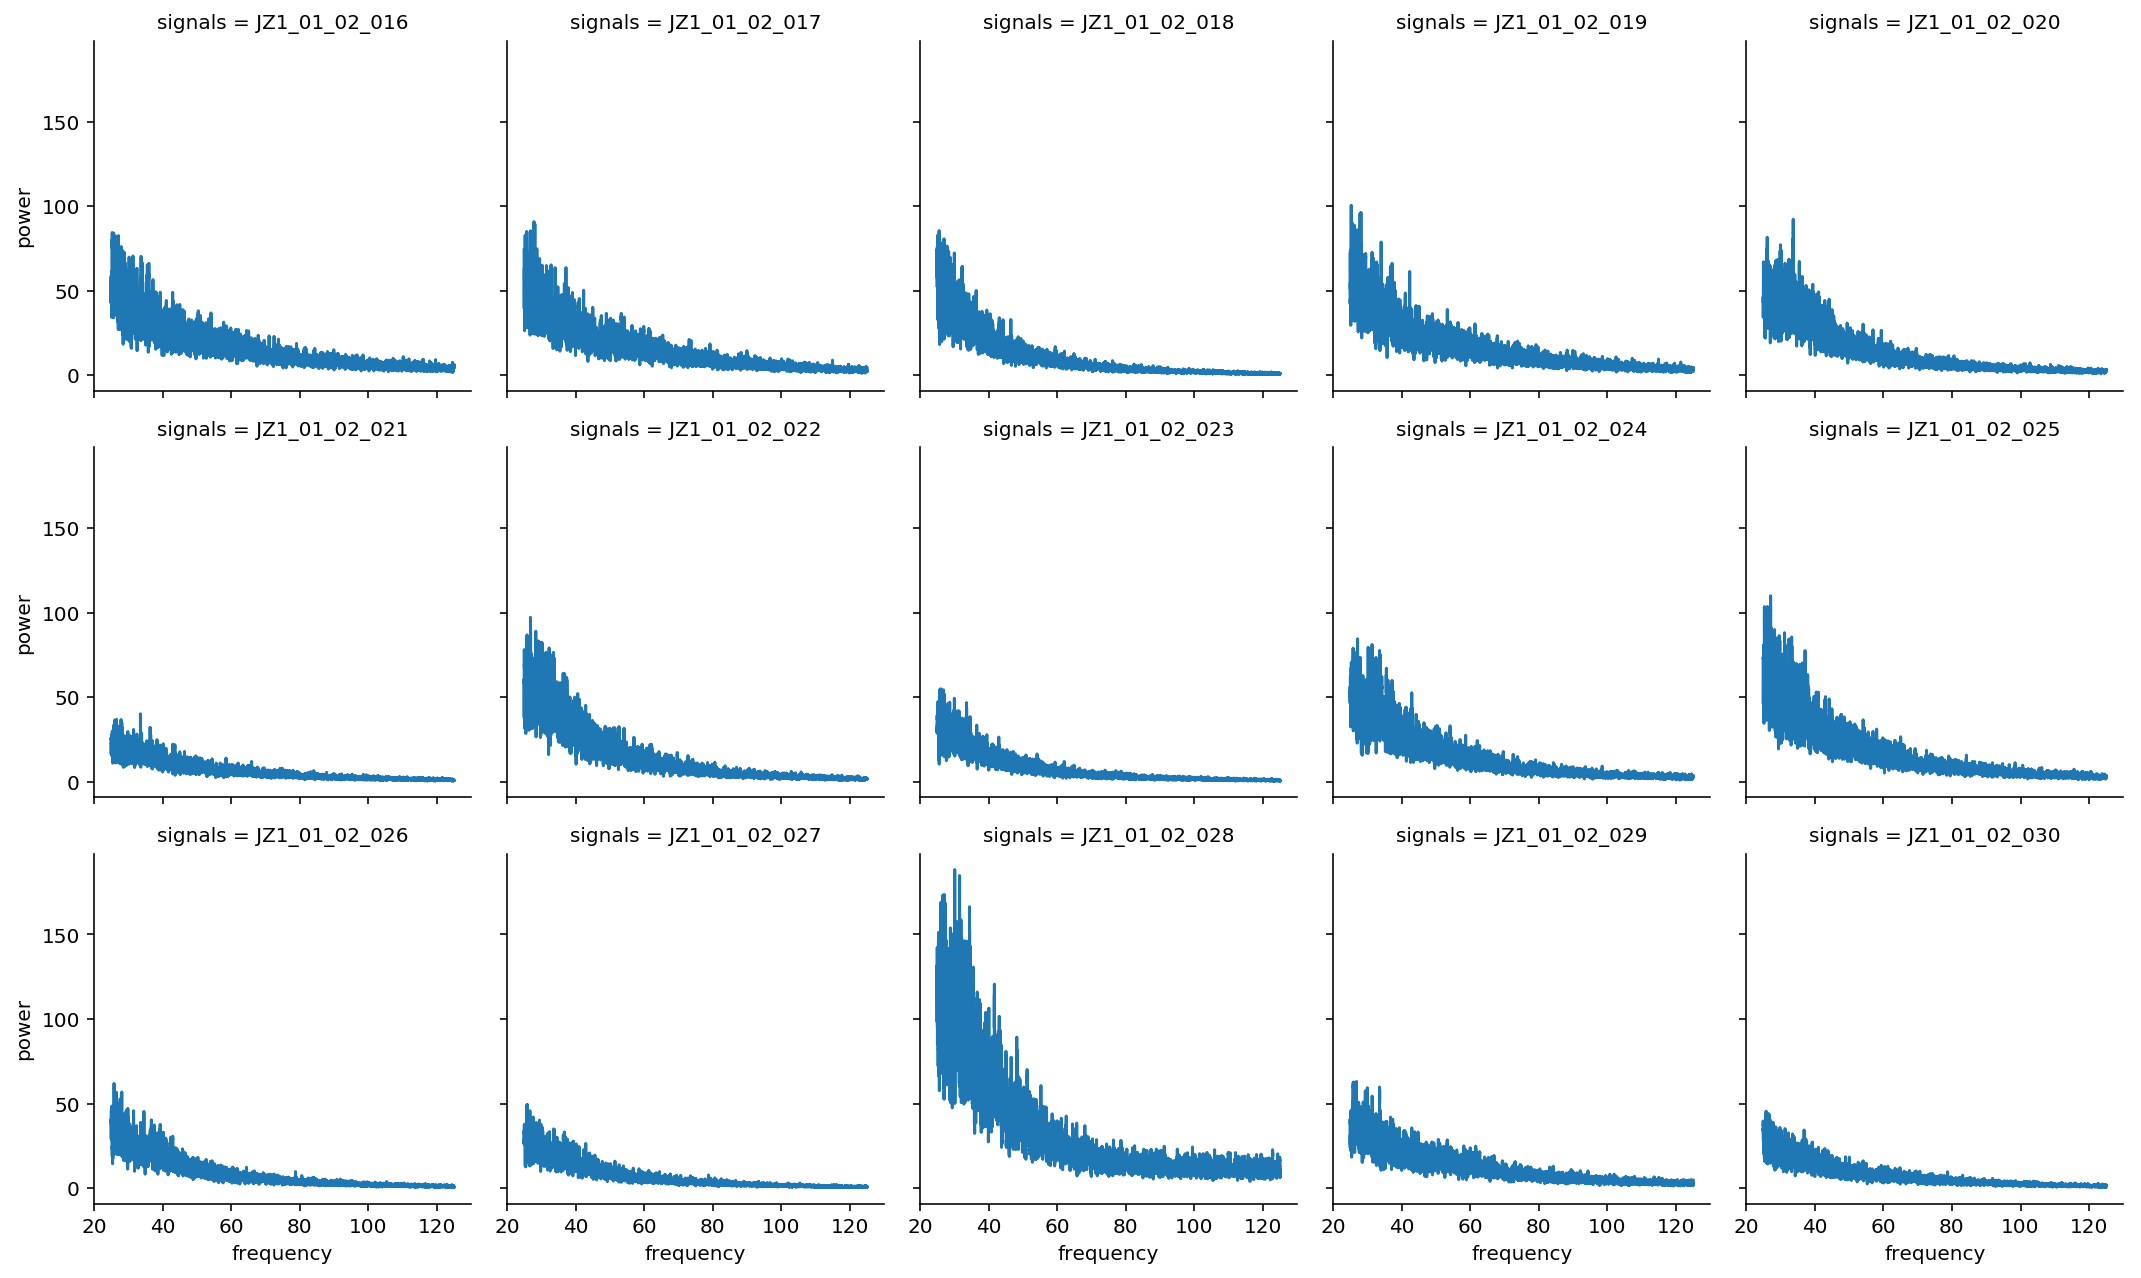

In [60]:
g = sns.FacetGrid(
    data=gamma_power.sel(frequency=slice(25, 125)).mean('time').to_dataframe().reset_index(),
    col='signals', col_wrap=5)
g.map(plt.plot, 'frequency', 'power')

Make sure MEC theta exists (~90 Hz)

In [ ]:
mec_keys = tetrode_info.query('area == "mec"').index
mec_lfps = lfdp.get_LFPs(mec_keys, ANIMALS)
m = spectral_connectivity.Multitaper(
    mec_lfps[speed > 4].values, sampling_frequency, time_window_duration=0.200,
    time_halfbandwidth_product=3, start_time=mec_lfps.index.total_seconds()[0])
c = spectral_connectivity.Connectivity.from_multitaper(m)
gamma_power = xr.DataArray(
    c.power(), dims=('time', 'frequency', 'signals'),
    coords=dict(time=c.time + m.time_window_duration / 2, frequency=c.frequencies,
                signals=tetrode_info.query('area == "mec"').tetrode_id), name='power')
m.frequency_resolution

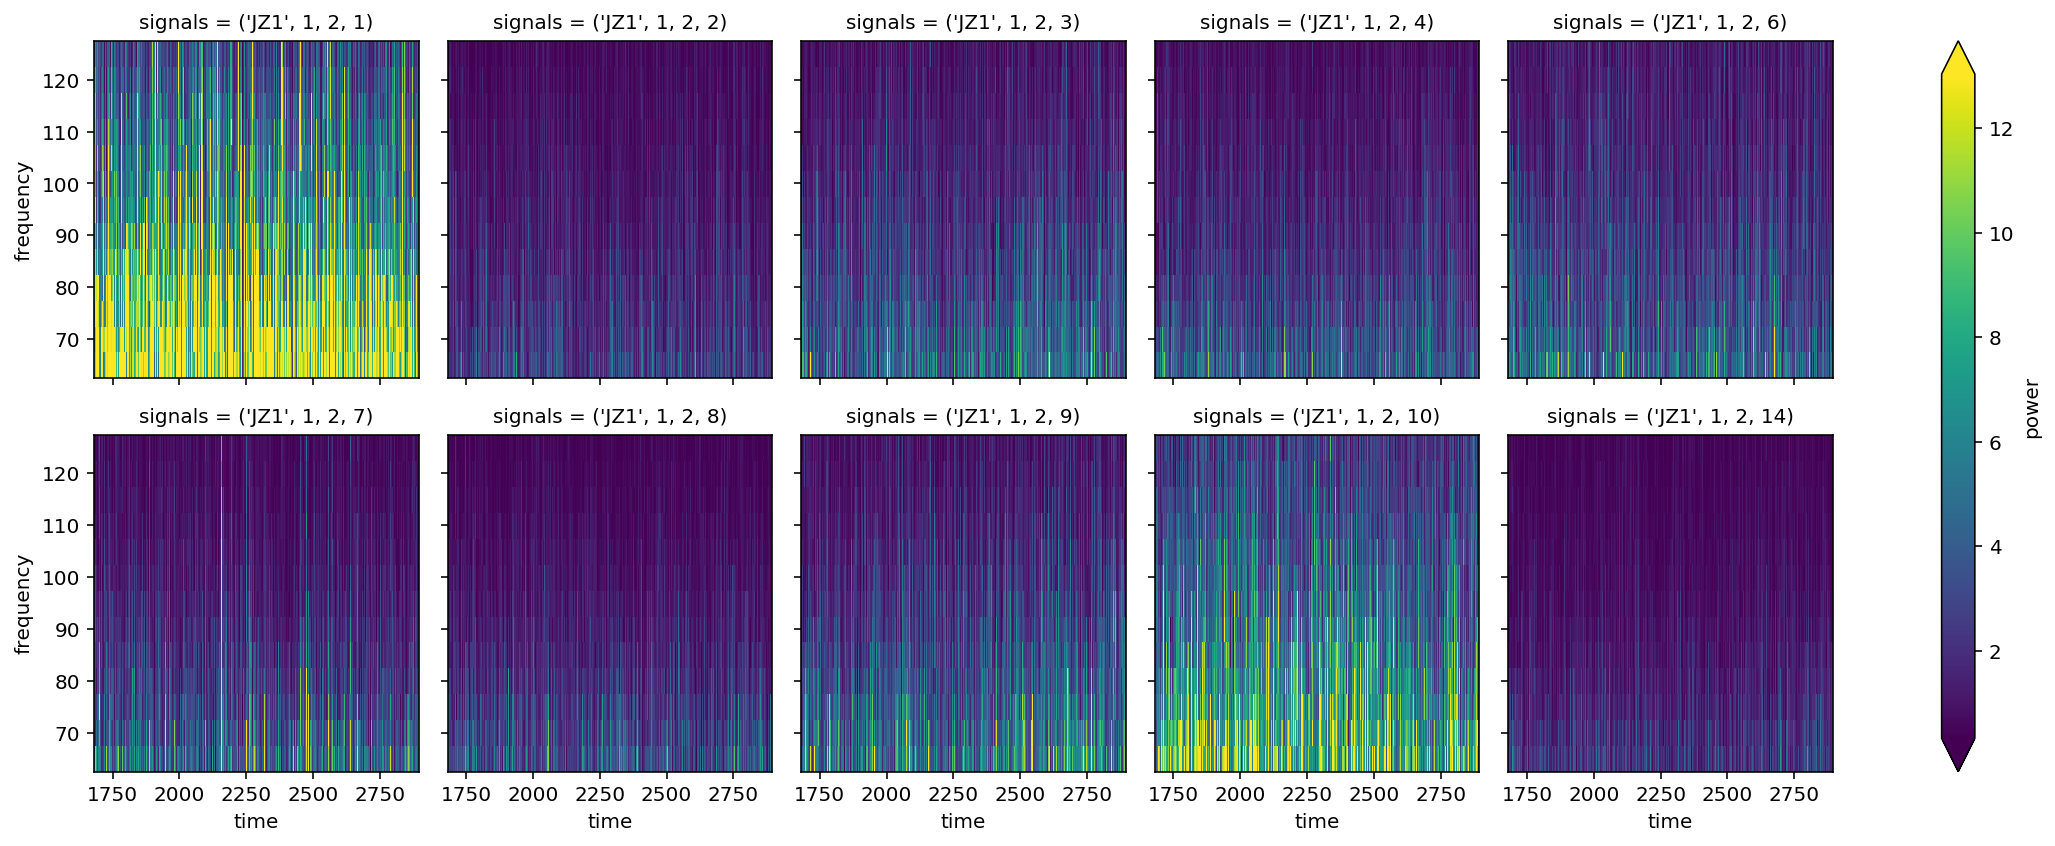

In [21]:
gamma_power.sel(frequency=slice(25, 125)).plot(x='time', y='frequency', col='signals', col_wrap=5, robust=True);

In [51]:
m = spectral_connectivity.Multitaper(
    mec_lfps[speed > 4].values, sampling_frequency,
    time_halfbandwidth_product=9, start_time=mec_lfps.index.total_seconds()[0])
c = spectral_connectivity.Connectivity.from_multitaper(m)
gamma_power = xr.DataArray(
    c.power(), dims=('time', 'frequency', 'signals'),
    coords=dict(time=c.time + m.time_window_duration / 2, frequency=c.frequencies,
                signals=tetrode_info.query('area == "mec"').tetrode_id), name='power')


INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=9,
           time_window_duration=292.24, time_window_step=292.24,
           detrend_type='constant', start_time=1680.0852000000002, n_tapers=17)


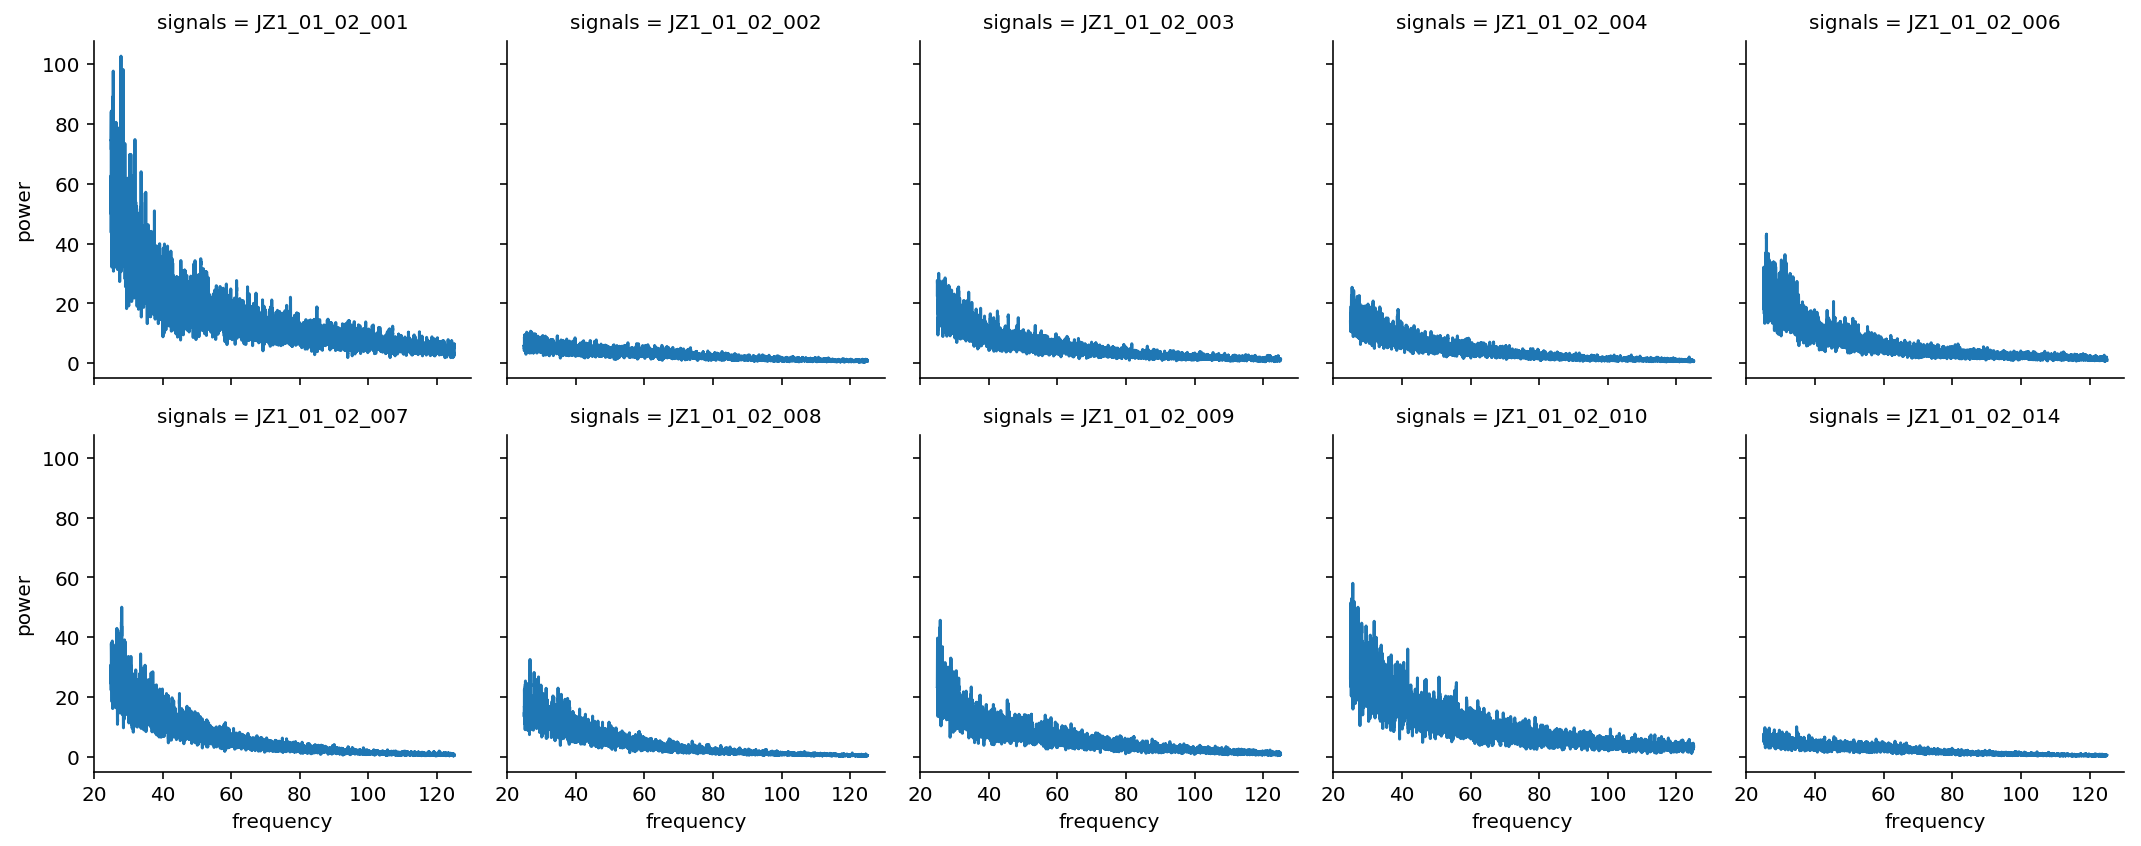

In [54]:
g = sns.FacetGrid(
    data=gamma_power.sel(frequency=slice(25, 125)).mean('time').to_dataframe().reset_index(),
    col='signals', col_wrap=5)
g.map(plt.plot, 'frequency', 'power')

## Neurons

Make sure we can get information about single units

In [56]:
neuron_info = lfdp.make_neuron_dataframe(ANIMALS).xs(epoch_key, drop_level=False)
neuron_info = pd.merge(
    neuron_info.reset_index('neuron_number'),
    tetrode_info.loc[:, ['area', 'subarea']], left_index=True, right_index=True
).set_index('neuron_number', append=True)
neuron_info

meanrate  numspikes  \
animal day epoch tetrode_number neuron_number                             
JZ1    1   2     2              1                 345.662322         42   
                 3              1                 172.831161         21   
                 10             1                7044.927323        856   
                                2                4049.187200        492   
                 12             1                  82.300553         10   
                 13             1               33175.352850       4031   
                 14             1                   8.230055          1   
                                2                   0.000000          0   
                                3                   0.000000          0   
                                4                 106.990719         13   
                 16             1                   8.230055          1   
                                2                1201.588071        146   
                                3                6682.804891        812   
                                4              474372.156516      57639   
                 17             1               21389.913683       2599   
                                2                6584.044227        800   
                 20             1                   8.230055          1   
                                2                 658.404423         80   
                                3                 197.521327         24   
                 24             1               19562.841410       2377   
                 26             1                   8.230055          1   
                 27             1               88440.174082      10746   
                                2              252498.096114      30680   
                 28             1               33907.827770       4120   
                                2               96011.824943      11666   
                                3               17875.680077       2172   
                                4               16056.837859       1951   
                                5               21719.115895       2639   
                                6               35060.035510       4260   
                                7               10756.682256       1307   
                                8               19291.249586       2344   
                                9                9423.413300       1145   

                                               spikewidth          neuron_id  \
animal day epoch tetrode_number neuron_number                                  
JZ1    1   2     2              1                     NaN  JZ1_01_02_002_001   
                 3              1                     NaN  JZ1_01_02_003_001   
                 10             1                     NaN  JZ1_01_02_010_001   
                                2                     NaN  JZ1_01_02_010_002   
                 12             1                     NaN  JZ1_01_02_012_001   
                 13             1                     NaN  JZ1_01_02_013_001   
                 14             1                     NaN  JZ1_01_02_014_001   
                                2                     NaN  JZ1_01_02_014_002   
                                3                     NaN  JZ1_01_02_014_003   
                                4                     NaN  JZ1_01_02_014_004   
                 16             1                     NaN  JZ1_01_02_016_001   
                                2                     NaN  JZ1_01_02_016_002   
                                3                     NaN  JZ1_01_02_016_003   
                                4                     NaN  JZ1_01_02_016_004   
                 17             1                     NaN  JZ1_01_02_017_001   
                                2                     NaN  JZ1_01_02_017_002   
                 20             1                     NaN  JZ

In [57]:
neuron_key = ('JZ1', 1, 2, 2, 1)
lfdp.get_spikes_dataframe(neuron_key, ANIMALS)

NotImplementedError: Please use HDF reader for matlab v7.3 files

In [37]:
neuron_key = ('JZ1', 1, 2, 2, 1)
lfdp.get_spike_indicator_dataframe(neuron_key, ANIMALS)

time
00:28:00.085200    0
00:28:00.085867    0
00:28:00.086533    0
00:28:00.087200    0
00:28:00.087867    0
00:28:00.088533    0
00:28:00.089200    0
00:28:00.089867    0
00:28:00.090533    0
00:28:00.091200    0
00:28:00.091867    0
00:28:00.092533    0
00:28:00.093200    0
00:28:00.093867    0
00:28:00.094533    0
00:28:00.095200    0
00:28:00.095867    0
00:28:00.096533    0
00:28:00.097200    0
00:28:00.097867    0
00:28:00.098533    0
00:28:00.099200    0
00:28:00.099867    0
00:28:00.100533    0
00:28:00.101200    0
00:28:00.101867    0
00:28:00.102533    0
00:28:00.103200    0
00:28:00.103867    0
00:28:00.104533    0
                  ..
00:48:15.124533    0
00:48:15.125200    0
00:48:15.125867    0
00:48:15.126533    0
00:48:15.127200    0
00:48:15.127867    0
00:48:15.128533    0
00:48:15.129200    0
00:48:15.129867    0
00:48:15.130533    0
00:48:15.131200    0
00:48:15.131867    0
00:48:15.132533    0
00:48:15.133200    0
00:48:15.133867    0
00:48:15.134533    0
00:48:15

In [55]:
from src.visualization import plot_perievent_raster

ca1_neuron_keys = neuron_info.query('area == "ca1"').index
n_neurons = len(ca1_neuron_keys)

col_wrap = 5
n_rows = np.ceil(n_neurons / col_wrap).astype(int)

fig, axes = plt.subplots(n_rows, col_wrap, figsize=(col_wrap * 3, n_rows * 3), sharex=True, sharey=True)
for ax, neuron_key in zip(axes.ravel(), ca1_neuron_keys):
    plot_perievent_raster(neuron_key, ANIMALS, ripple_times,
                          tetrode_info, window_offset=(-0.5, 0.5),
                          ax=ax, s=1)
    
for ax in axes.ravel()[n_neurons:]:
    ax.axis('off')

plt.tight_layout()

NameError: name 'neuron_info' is not defined

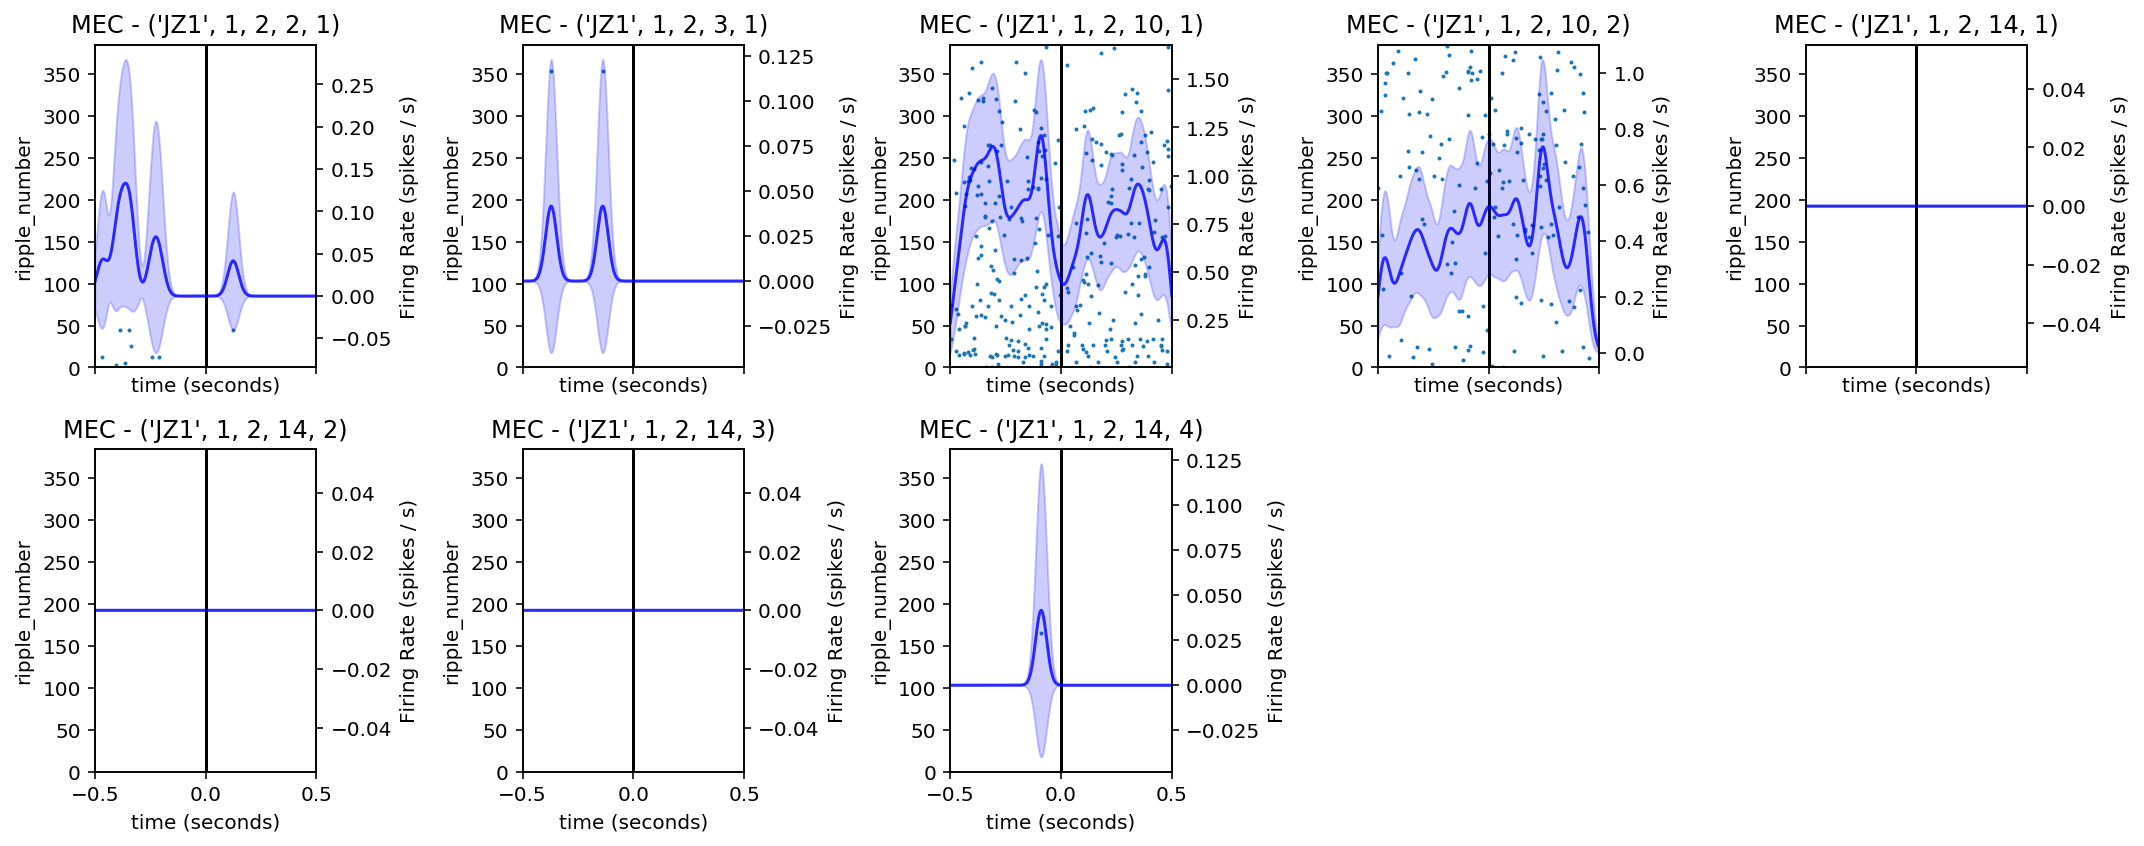

In [37]:
mec_neuron_keys = neuron_info.query('area == "mec"').index
n_neurons = len(mec_neuron_keys)

col_wrap = 5
n_rows = np.ceil(n_neurons / col_wrap).astype(int)

fig, axes = plt.subplots(n_rows, col_wrap, figsize=(col_wrap * 3, n_rows * 3), sharex=True, sharey=True)
for ax, neuron_key in zip(axes.ravel(), mec_neuron_keys):
    plot_perievent_raster(neuron_key, ANIMALS, ripple_times,
                          tetrode_info, window_offset=(-0.5, 0.5),
                          ax=ax, s=1)
    
for ax in axes.ravel()[n_neurons:]:
    ax.axis('off')

plt.tight_layout()

## Multiunit Data

In [46]:
tetrode_key = ('JZ1', 1, 2, 27)
lfdp.get_multiunit_indicator_dataframe(tetrode_key, ANIMALS)

channel_1_max  channel_2_max  channel_3_max  channel_4_max
time                                                                       
00:28:00.085200            NaN            NaN            NaN            NaN
00:28:00.085867            NaN            NaN            NaN            NaN
00:28:00.086533            NaN            NaN            NaN            NaN
00:28:00.087200            NaN            NaN            NaN            NaN
00:28:00.087867            NaN            NaN            NaN            NaN
00:28:00.088533            NaN            NaN            NaN            NaN
00:28:00.089200            NaN            NaN            NaN            NaN
00:28:00.089867            NaN            NaN            NaN            NaN
00:28:00.090533            NaN            NaN            NaN            NaN
00:28:00.091200            NaN            NaN            NaN            NaN
00:28:00.091867            NaN            NaN            NaN            NaN
00:28:00.092533            NaN            NaN            NaN            NaN
00:28:00.093200            NaN            NaN            NaN            NaN
00:28:00.093867            NaN            NaN            NaN            NaN
00:28:00.094533            NaN            NaN            NaN            NaN
00:28:00.095200            NaN            NaN            NaN            NaN
00:28:00.095867            NaN            NaN            NaN            NaN
00:28:00.096533            NaN            NaN            NaN            NaN
00:28:00.097200            NaN            NaN            NaN            NaN
00:28:00.097867            NaN            NaN            NaN            NaN
00:28:00.098533            NaN            NaN            NaN            NaN
00:28:00.099200            NaN            NaN            NaN            NaN
00:28:00.099867            NaN            NaN            NaN            NaN
00:28:00.100533            NaN            NaN            NaN            NaN
00:28:00.101200            NaN            NaN            NaN            NaN
00:28:00.101867            NaN            NaN            NaN            NaN
00:28:00.102533            NaN            NaN            NaN            NaN
00:28:00.103200            NaN            NaN            NaN            NaN
00:28:00.103867            NaN            NaN            NaN            NaN
00:28:00.104533            NaN            NaN            NaN            NaN
...                        ...            ...            ...            ...
00:48:15.124533            NaN            NaN            NaN            NaN
00:48:15.125200            NaN            NaN            NaN            NaN
00:48:15.125867            NaN            NaN            NaN            NaN
00:48:15.126533            NaN            NaN            NaN            NaN
00:48:15.127200            NaN            NaN            NaN            NaN
00:48:15.127867            NaN            NaN            NaN            NaN
00:48:15.128533     110.623116     132.679398     306.368744     160.444214
00:48:15.129200            NaN            NaN            NaN            NaN
00:48:15.129867            NaN            NaN            NaN            NaN
00:48:15.130533            NaN            NaN            NaN            NaN
00:48:15.131200            NaN            NaN            NaN            NaN
00:48:15.131867            NaN            NaN            NaN            NaN
00:48:15.132533            NaN            NaN            NaN            NaN
00:48:15.133200            NaN            NaN            NaN            NaN
00:48:15.133867            NaN            NaN            NaN            NaN
00:48:15.134533            NaN            NaN            NaN            NaN
00:48:15.135200            NaN            NaN            NaN            NaN
00:48:15.135867            NaN            NaN            NaN            NaN
00:48:15.136533            NaN            NaN            NaN            NaN
00:48:15.137200            NaN            NaN            NaN     

In [45]:
a = lfdp.get_multiunit_dataframe(tetrode_key, ANIMALS)
a

channel_1_max  channel_2_max  channel_3_max  channel_4_max
time                                                                       
00:00:01.413133     184.418549     141.362183     313.659149     162.116058
00:00:02.679467     226.921173     310.717224     190.680511     190.815979
00:00:03.628167     245.649460     309.573273     213.229294     172.984024
00:00:06.448167     135.292221     313.716980     186.200439     192.125076
00:00:07.754767     128.056259     200.693008     302.415527     160.819122
00:00:07.816133     192.586624     309.585876     177.860336     205.485870
00:00:07.819600     228.763474     275.468964     311.211884     279.035767
00:00:10.427000     269.957520     134.654083     310.398956      37.037750
00:00:10.438200     269.957520     134.654083     310.398956      37.037750
00:00:10.538467     179.733856     332.152527      94.634483     152.757553
00:00:10.841967     304.311829     203.001205     247.106354     218.986099
00:00:14.895100     265.384583     210.157318     326.482330     317.039062
00:00:15.427467     300.289337     200.584305     300.908905     199.852753
00:00:15.543267     309.263763     328.429443     245.016022     344.923370
00:00:15.549267     369.833954     331.170166     343.201843     340.123322
00:00:15.717133     317.203003     229.367355     170.456573     170.273270
00:00:15.960033     311.598358     247.987274     288.170746     255.624329
00:00:16.934267     174.808380     111.014366     338.313995     107.682617
00:00:16.938633     162.549728     145.475708     311.897339     197.981079
00:00:17.930833     190.509384     317.044037     113.437309      76.286079
00:00:23.088667     185.253143     286.730133     315.673615     139.647522
00:00:23.099667     162.705032     319.621674     202.789749     169.278702
00:00:23.533867     118.622993     154.145416     322.195831     135.002182
00:00:24.305467     146.597351     302.017395     100.585091     146.765381
00:00:25.384733     132.494385     302.765350      78.960426     124.754898
00:00:27.246433     114.227448      77.022888     301.597046     107.442528
00:00:29.639600     215.619583     315.031403     213.547684     194.025085
00:00:32.820300     124.578125      74.360641     306.182922     127.970947
00:00:33.302033     178.512115     200.705109     371.237518     131.262894
00:00:34.619267     274.101410     163.071701     336.763824     190.626572
...                        ...            ...            ...            ...
03:48:46.537200     145.108917      91.798355     303.454254     235.707901
03:48:48.230100     128.242294      67.098244     329.547455      95.226044
03:48:48.817767     162.684998     102.922066     434.723663     192.367508
03:48:49.035633      71.982895     111.339241     310.824005     136.756790
03:48:49.720800     210.660248     205.732346     318.698761     147.335037
03:48:50.289933     158.643036     103.662903     344.113525     107.968536
03:48:50.454433     118.935997      23.139704     326.120148       6.966699
03:48:51.650200     168.437134     306.765350     162.328827     124.836281
03:48:55.311733      70.946053     121.500755     323.068939      99.608528
03:48:56.457567     188.159195     131.188904     307.770996      70.713455
03:48:56.751833     270.062500     306.949951     144.775803     185.165894
03:48:56.768267     325.614319     335.387115     202.742233     228.479065
03:48:58.426500     109.794998     118.891060     308.448944     115.969269
03:48:59.185033     184.019852     176.410660     333.286224     159.110657
03:48:59.277533     182.361481     146.925491     329.855499     173.078568
03:48:59.685467     335.108398     283.386505     265.090240     240.828720
03:48:59.869267     182.195969     304.673065     131.910446     101.847359
03:48:59.936800     357.761841     250.257431     218.821701     215.627197
03:49:00.191500     339.369537     316.659546     242.629822     328.922119
03:49:00.212133     339.369537     316.659546     242.629822     

In [38]:
lfdp.get_multiunit_indicator_dataframe(tetrode_key, ANIMALS).dropna()

channel_1_max  channel_2_max  channel_3_max  channel_4_max
time                                                                       
00:28:00.107200      67.709686      37.371429     300.792480      55.723942
00:28:00.131200     154.771637     137.892899     335.941650     165.771957
00:28:00.137867     145.225220      76.680878     521.251465     185.716415
00:28:00.159867       9.553318     154.974472     404.274780      75.635735
00:28:00.173867     135.202560     111.238876     227.023712     438.158722
00:28:00.181200     341.283661     207.499802     292.621735     328.535797
00:28:00.205200      40.592777     126.345924     344.211273     371.289062
00:28:00.206533     103.001640     146.227249     384.522980     484.709290
00:28:00.213867     306.204224     426.764130     382.299866     562.024475
00:28:00.246533     162.957855     229.075058     471.660278      89.939270
00:28:00.297200      69.631226      74.043541     334.737854     219.910782
00:28:00.301867     488.601074     502.996155     575.638916     725.389832
00:28:00.320533     435.106934     416.268890     581.200500     658.954590
00:28:00.341200     460.222198     456.469269     653.029663     663.580566
00:28:00.355867       3.686822      44.311714      62.439953     308.740814
00:28:00.361867      96.883461     120.142921      93.548714     315.256378
00:28:00.391867      72.993530      -5.727451     338.452271      61.269890
00:28:00.403200     121.131210     -14.924055     173.746811     333.485565
00:28:00.412533      84.492516     130.519531     464.249420     111.653191
00:28:00.457867      95.885147      35.659325     221.831100     438.911926
00:28:00.481867      19.145666      49.373322      97.529251     349.260010
00:28:00.500533      35.137936     -80.672401     102.227760     336.476135
00:28:00.523200     200.279846     338.799927     347.648621     229.516769
00:28:00.526533     200.279846     338.799927     347.648621     229.516769
00:28:00.529867     355.533844     325.540070     427.066589     550.805603
00:28:00.549867     174.658768      63.722252     360.527496     131.327545
00:28:00.597200     165.768784      49.566711     162.128494     473.508789
00:28:00.676533      49.125633      85.934395     335.160736      67.135216
00:28:00.697867      39.944336      62.106651     161.938675     346.306732
00:28:00.710533     508.212158     488.848969     641.856262     723.193176
...                        ...            ...            ...            ...
00:48:14.504533     486.331238     469.841370     756.231873     779.913513
00:48:14.523867     484.773376     473.493713     585.861023     753.603088
00:48:14.535200     238.087982     403.265625     389.927673     371.165192
00:48:14.542533     311.386963     313.202118     503.943207     574.549866
00:48:14.566533     462.971954     436.200439     662.991089     694.234253
00:48:14.601867     148.182373     263.507599     303.503723      85.315056
00:48:14.609200     106.312073     352.324219      88.767677      55.279675
00:48:14.621200     279.083374     316.789642     450.097412     627.299683
00:48:14.627867      61.016953     108.703117     390.051086     -16.363085
00:48:14.642533     372.323578     355.379120     491.363098     613.286682
00:48:14.647200     129.096222      30.021950     321.966187     216.979126
00:48:14.683200      85.979385      44.887371      96.478821     343.011383
00:48:14.753200       1.966086     101.574707     339.284668     142.116837
00:48:14.767200     531.317871     515.931702     373.346558     511.664948
00:48:14.769867     531.317871     515.931702     373.346558     511.664948
00:48:14.787200      31.054176      99.247208      69.150009     444.263031
00:48:14.789200     -58.786720      -2.138973     319.588501      17.590382
00:48:14.805867      95.028458      57.427643      50.316971     376.177185
00:48:14.810533     262.248566     316.869141     442.043732     197.615067
00:48:14.819867     255.678452     359.530365     290.398682     

In [23]:
from src.visualization import plot_perievent_raster

ca1_keys = tetrode_info.query('area == "ca1"').index
n_tetrodes = len(ca1_keys)
col_wrap = 5
n_rows = np.ceil(n_tetrodes / col_wrap).astype(int)

fig, axes = plt.subplots(1, 1, figsize=(col_wrap * 3, n_rows * 3), sharex=True, sharey=True)
for ax, tetrode_key in zip(axes.ravel(), ca1_keys):
tetrode_key = ca1_keys[0]
plot_perievent_raster(tetrode_key, ANIMALS, ripple_times,
                      tetrode_info, window_offset=(-0.5, 0.5),
                      ax=ax, s=1)

IndentationError: expected an indented block (<ipython-input-23-b6b645242ec5>, line 10)

In [ ]:
for ax in axes.ravel()[n_tetrodes:]:
    ax.axis('off')
plt.tight_layout()

In [1]:
from src.visualization import plot_perievent_raster

ca1_keys = tetrode_info.query('area == "ca1"').index
n_tetrodes = len(ca1_keys)
col_wrap = 5
n_rows = np.ceil(n_tetrodes / col_wrap).astype(int)

fig, axes = plt.subplots(n_rows, col_wrap, figsize=(col_wrap * 3, n_rows * 3), sharex=True, sharey=True)
for ax, tetrode_key in zip(axes.ravel(), ca1_keys):
    plot_perievent_raster(tetrode_key, ANIMALS, ripple_times,
                          tetrode_info, window_offset=(-0.5, 0.5),
                          ax=ax, s=1)
    
for ax in axes.ravel()[n_tetrodes:]:
    ax.axis('off')
plt.tight_layout()

NameError: name 'tetrode_info' is not defined

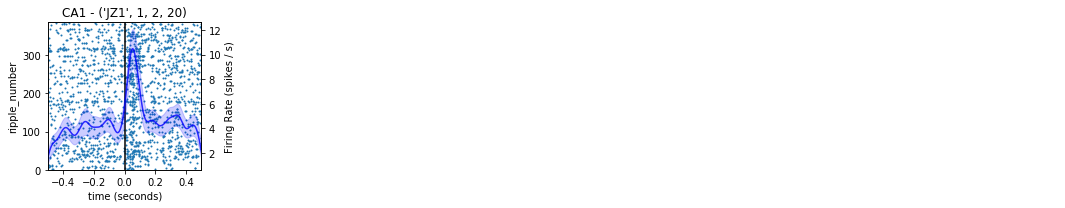

In [40]:
from src.visualization import plot_perievent_raster
ca1_keys = tetrode_info.query('tetrode_number == 20').index
n_tetrodes = len(ca1_keys)
col_wrap = 5
n_rows = np.ceil(n_tetrodes / col_wrap).astype(int)

fig, axes = plt.subplots(n_rows, col_wrap, figsize=(col_wrap * 3, n_rows * 3), sharex=True, sharey=True)
for ax, tetrode_key in zip(axes.ravel(), ca1_keys):
    plot_perievent_raster(tetrode_key, ANIMALS, ripple_times,
                          tetrode_info, window_offset=(-0.5, 0.5),
                          ax=ax, s=1)
    
for ax in axes.ravel()[n_tetrodes:]:
    ax.axis('off')
plt.tight_layout()

In [28]:
ripple_times

start_time        end_time
ripple_number                                
1             00:28:03.733867 00:28:03.821867
2             00:28:04.379200 00:28:04.437867
3             00:28:07.081867 00:28:07.135200
4             00:28:08.576533 00:28:08.680533
5             00:28:09.424533 00:28:09.501200
6             00:28:13.159200 00:28:13.207200
7             00:28:13.710533 00:28:13.776533
8             00:28:14.932533 00:28:15.001200
9             00:28:16.880533 00:28:16.961867
10            00:28:19.627867 00:28:19.706533
11            00:28:34.423200 00:28:34.734533
12            00:28:35.351200 00:28:35.719200
13            00:28:39.040533 00:28:39.099867
14            00:28:39.481200 00:28:39.554533
15            00:28:40.797200 00:28:40.913200
16            00:28:41.599200 00:28:41.693200
17            00:28:41.745200 00:28:41.881200
18            00:28:41.889200 00:28:41.941867
19            00:28:42.887867 00:28:43.182533
20            00:28:46.689867 00:28:46.747200
21            00:28:46.907867 00:28:46.964533
22            00:28:47.111867 00:28:47.191867
23            00:28:47.287867 00:28:47.331867
24            00:28:48.939200 00:28:48.997867
25            00:28:49.837200 00:28:49.895867
26            00:28:51.035867 00:28:51.097867
27            00:28:52.433200 00:28:52.499200
28            00:28:53.037200 00:28:53.093867
29            00:28:54.118533 00:28:54.175867
30            00:28:57.065866 00:28:57.110533
...                       ...             ...
355           00:46:47.846533 00:46:48.002533
356           00:46:52.401200 00:46:52.519200
357           00:46:54.272533 00:46:54.391867
358           00:46:55.495200 00:46:55.540533
359           00:47:00.201200 00:47:00.272533
360           00:47:00.670533 00:47:00.720533
361           00:47:01.207200 00:47:01.247867
362           00:47:03.746533 00:47:03.834533
363           00:47:06.873200 00:47:06.920533
364           00:47:10.161200 00:47:10.259200
365           00:47:20.131867 00:47:20.201200
366           00:47:21.204533 00:47:21.275200
367           00:47:26.610533 00:47:26.661200
368           00:47:27.337867 00:47:27.445200
369           00:47:27.779867 00:47:27.872533
370           00:47:32.038533 00:47:32.137867
371           00:47:32.321867 00:47:32.401867
372           00:47:34.004533 00:47:34.095200
373           00:47:34.160533 00:47:34.266533
374           00:47:34.854533 00:47:34.911200
375           00:47:35.237200 00:47:35.306533
376           00:47:38.977867 00:47:39.070533
377           00:47:39.923200 00:47:39.998533
378           00:47:40.114533 00:47:40.220533
379           00:47:44.371867 00:47:44.476533
380           00:47:46.019867 00:47:46.074533
381           00:47:47.877200 00:47:47.968533
382           00:47:49.119200 00:47:49.192533
383           00:47:49.429200 00:47:49.509866
384           00:48:02.653200 00:48:02.783867

[384 rows x 2 columns]

## DIO

In [345]:
from loren_frank_data_processing.core import get_data_structure

def get_DIO(epoch_key, animals):
    ''''''
    animal, day, epoch = epoch_key
    pins = get_data_structure(animals[animal], day, 'DIO', 'DIO')[epoch - 1].squeeze()
    column_names = pins[0].dtype.names
    pins_df = []
    
    for pin in pins:
        time = pin['times'][0, 0].squeeze()
        if time.size > 1:
            time = pd.to_timedelta(time, unit='s')

            values = pin['values'][0, 0].squeeze()
            pin_id = pin['original_id'][0, 0].item()

            pins_df.append(
                pd.Series(values, index=[time], name=pin_id))
    return pd.concat(pins_df, axis=1)